# Preliminary setup and data exploration

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(100)
np.random.seed(100)

In [3]:
from src.agents import *

In [4]:
#data = pd.read_csv('data/movielens_10_arms.csv') #easy
#data = pd.read_csv('data/yahoo_reduced_arms.csv') #harder
#data = pd.read_csv('data/movielens_202_arms.csv') #lots of arms
data = pd.read_csv('data/10000dataset.csv')
# Reshuffle data
data = data.sample(frac=1, random_state=100)
data = data.reset_index()

In [19]:
n_features = 0
for column in data.columns:
    try:
        column = int(column)
        n_features = max(column, n_features)
    except:
        pass
n_features += 1

n_features

100

In [5]:
# Number of arms
n_arms = data['selected_arm'].max() + 1
n_arms = int(n_arms)
n_arms

10

In [6]:
data.sample(n=5, random_state=100)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,selected_arm,reward
9815,43,0,1,30,1,0,0,0,0,0,...,0,0,0,0,0,19,0,1,7,0
2780,30,0,1,41,1,0,0,0,0,0,...,0,0,0,0,0,11,0,1,3,0
7167,27,0,0,27,0,0,0,0,0,0,...,0,0,0,0,0,15,0,2,8,0
4639,6,7,0,39,0,0,22,0,0,0,...,6,1,0,3,1,0,0,5,0,0
9137,44,0,4,34,0,0,0,0,0,0,...,0,0,0,0,0,20,0,1,5,0


In [7]:
data.shape

(10000, 102)

There are 22 different arms. They seem to have been chosen uniformly randomly:

In [8]:
data['selected_arm'].describe()

count    10000.000000
mean         4.489600
std          2.868609
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: selected_arm, dtype: float64

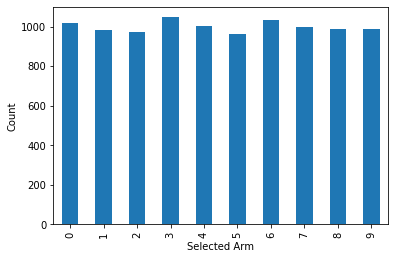

In [9]:
data['selected_arm'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Selected Arm')
plt.ylabel('Count')
plt.show()

The reward is a Bernoulli distribution:

In [10]:
data['reward'].describe()

count    10000.000000
mean         0.103900
std          0.305146
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: reward, dtype: float64

The reward expectancy depends on the arm chosen:

Text(0.5, 0, 'Selected Arm')

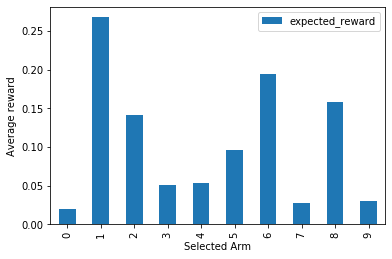

In [11]:
expected_reward = data.groupby('selected_arm').agg({'reward':'mean'}).rename({'reward':'expected_reward'},axis=1)
expected_reward.plot(kind='bar')
plt.ylabel('Average reward')
plt.xlabel('Selected Arm')

In [12]:
data.groupby('selected_arm').agg({'reward':'mean'}).sort_values('reward', ascending=False)

,reward
selected_arm,
1,0.267821
6,0.194203
8,0.158907
2,0.141684
5,0.096573
4,0.053731
3,0.051576
9,0.030395
7,0.028028


All 136 features are bernoulli

# Using PCA to lower the number of dimensions

In [28]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=4)
X = pca.fit_transform(data[[str(i) for i in range(n_features)]])

In [29]:
data = pd.concat([pd.DataFrame(X), data[['selected_arm', 'reward']]], axis=1)

In [30]:
data

,0,1,2,3,selected_arm,reward
0,0.862381,15.824105,-4.728823,15.846460,1,0
1,-36.641955,-42.565999,-0.982176,8.473514,7,0
2,-28.908081,47.025209,78.836566,-21.715712,4,0
3,-24.208872,48.231416,74.760137,-19.219603,3,0
4,10.075641,13.394291,-2.872530,27.707311,1,1
...,...,...,...,...,...,...
9995,-36.450589,-42.686482,-2.199960,4.059316,0,0
9996,65.823293,-22.576758,3.729309,-17.962800,1,0
9997,-36.484401,-38.862534,-2.665262,5.289559,8,1
9998,26.334520,44.600940,-18.668215,65.341994,3,0


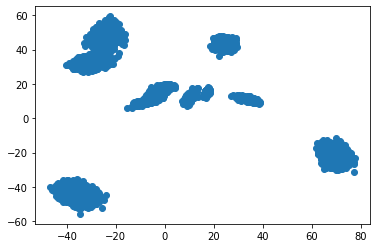

In [31]:
plt.scatter(data[0], data[1])

# Defining a base Agent other will be based upon

These are the basic properties of a multi-armed bandit.

In [16]:
Agent??

Init signature: Agent(n_arms)
Source:        
class Agent():
    """Base properties of all multi-armed bandits."""
    def __init__(self, n_arms):
        """
        n_arms: int
            Number of arms
        """
        self.n_arms = n_arms
        self.tries = np.zeros(n_arms)
        self.successes = np.zeros(n_arms)
        
    @property
    def _total_tries(self): 
        return self.tries.sum()
    
    def add_observation(self, arm, reward):
        """An observation consists of a pair `(arm,reward)`.
        arm: int
            Chosen arm of the observation
        reward: float
            Reward of the observation
        """
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        """Placeholder way of selecting an arm."""
        arm = self._total_tries % self.n_arms
        return arm
File:           ~/Repos/bandits/src/agents.py
Type:           type
Subclasses:     GreedyExploreFirst, EpsilonGreedy, UCB1, BayesUCB, 

# Experiments

This part will be used to log the results of the different bandit simulations (experiments).

In [17]:
T = n_arms * 200 # Number of steps in the simulations

In [18]:
class Experiment():
    def __init__(self, agent, environment, T, name='No experiment name'):
        self.name = name
        self.agent = agent
        self.environment = environment
        self.cumulative_reward_history = [0]
        for step in range(T):
            self._run_one_step()

    def _run_one_step(self):
        arm = self.agent.select_arm()
        reward = self.environment.get_reward(arm)
        self.agent.add_observation(arm, reward)
        cumulative_reward = self.cumulative_reward_history[-1] + reward
        self.cumulative_reward_history.append(cumulative_reward)

    def plot_cumulative_reward(self):
        plt.plot(self.cumulative_reward_history)
        plt.title('Cumulative Reward', fontsize=13)
        plt.xlabel('Tries')
        plt.ylabel('Cumulative Reward')

In [19]:
def plot_tries_vs_expected_reward(tries, reward):
    """Thanks to https://stackoverflow.com/a/31548279"""
    reward = reward.copy()
    reward['tries'] = tries
    width = .3
    reward['tries'].plot(kind='bar', color='#55A868', position=1, width=width, legend=True, figsize=(12,6))
    reward['expected_reward'].plot(kind='bar', color='#4C72B0', position=0, width=width, legend=True, secondary_y=True)
    plt.title('Total number of tries vs expected reward for each arm')
    plt.grid()
    plt.show()

In [20]:
experiment_history = []

# Contextual Agent

In [17]:
??BayesUCB

Init signature: BayesUCB(n_arms, c=2)
Source:        
class BayesUCB(Agent):
    """Assess UCB using knowledge of the Bernoulli distribution and it's conjugate prior, the Beta distribution."""
    def __init__(self, n_arms, c=2):
        """
        n_arms: int
            Number of arms
        c: float
            Amount of standard deviations considered for the UCB
        """
        super().__init__(n_arms)
        self.c = c # Amount of standard deviations considered for ucb
        self._params_a = np.ones(n_arms) # Params a of Beta
        self._params_b = np.ones(n_arms) # Params b of Beta
  
    def add_observation(self, arm, reward):
        """
        arm: int
            Arm chosen in the observation
        reward: bool
            Reward obtained in the observation
        """
        super().add_observation(arm,reward)
        self._params_a[arm] += reward
        self._params_b[arm] += 1 - reward
    
    def select_arm(self):
        # Start playing each arm once
   

In [33]:
class ContextualAgent(Agent):
    """Base properties of all contextual multi-armed bandits."""
    def __init__(self, n_arms, n_features):
        super().__init__(n_arms)
        self.n_features = n_features
    
    def add_observation(self, arm, reward, X):
        super().add_observation(arm, reward)

# Implementing LinUCB

In [ ]:


# def linUCB_disjoint(alpha, X, generate_reward, true_theta):
#     print("linUCB disjoint with exploration parameter alpha: ", alpha)
#     n_trial, n_arms, n_feature = X.shape
    
#     # 1.Initialise object
#     # 1.1.output object
#     arm_choice, r_payoff = [np.empty(n_trial) for _ in range(2)]
#     theta  = np.empty(shape=(n_trial, n_arms, n_feature)) #n_trial pour assurer la traçabilité. Il y a bien un vecteur théta par bras
#     p      = np.empty(shape=(n_trial, n_arms)) #n_trial pour la traçabilité
    
#     # 1.2.intermediate object
#     A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
#     b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

#     # 2. Algo
#     for t in np.arange(n_trial):
        
#         #Compute estimates (theta) and prediction (p) for all arms
#         for a in np.arange(n_arms) :
#             inv_A       = np.linalg.inv(A[a]) # caching matrix inversion result because used twice
#             theta[t, a] = inv_A.dot(b[a])
#             p[t, a]     = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
        
#         #chosing best arms
#         chosen_arm    = np.argmax(p[t])
#         x_chosen_arm  = X[t, chosen_arm]
#         r_payoff[t]   = generate_reward(arm=chosen_arm, x=x_chosen_arm, theta=true_theta)
#         arm_choice[t] = chosen_arm
        
#         #update intermediate objects (A and b)
#         A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
#         b[chosen_arm] += r_payoff[t] * x_chosen_arm
    
#     return dict(theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff)



In [37]:
class LinUCB(ContextualAgent):
    def __init__(self, n_arms, n_features, alpha=1):
        super().__init__(n_arms, n_features)
        self.alpha = alpha
        self._A = [np.identity(n_features) for arm in range(n_arms)] # One per arm
        self._b = [np.zeros([n_features, 1]) for arm in range(n_arms)] # One per arm
    
    def add_observation(self, arm, reward, X):
        super().add_observation(arm, reward, X)
        
    def _get_UCB(self, X):
        #x = x_array.reshape([-1,1])
        A_inv = [np.linalg.inv(self._A[arm]) for arm in range(n_arms)]
        theta = [np.dot(A_inv[arm], self._b[arm]) for arm in range(n_arms)]
        UCB = [np.dot(theta[arm].T, X) +  self.alpha * np.sqrt(np.dot(X.T, np.dot(A_inv[arm],x))) for arm in range(n_arms)]
        return UCB
    
    def select_arm(self, X):
        UCB = self._get_UCB(X)
        arm = argmax(UCB))

In [ ]:
#     def reward_update(self, reward, x_array):
#         # Reshape covariates input into (d x 1) shape vector
#         x = x_array.reshape([-1,1])
        
#         # Update A which is (d * d) matrix.
#         self.A += np.dot(x, x.T)
        
#         # Update b which is (d x 1) vector
#         # reward is scalar
#         self.b += reward * x

In [39]:
??UCB1

Init signature: UCB1(n_arms)
Source:        
class UCB1(Agent):
    """This uses the concept of 'optimism under uncertainty'.
    
    We assume the expected reward of each arm is the upper confidence bound (UCB) of the arm so far.

    The confidence radius is calculated using Hoeffding’s Inequality."""
    @property
    def _confidence_radius(self):
        radius = np.sqrt(2 * np.log(self._total_tries) / self.tries)
        return radius
    
    @property
    def _ucb(self):
        success_rate = self.successes / self.tries
        return success_rate + self._confidence_radius
    
    def select_arm(self):
        # Start playing each arm once
        if self._total_tries < self.n_arms:
            arm = self._total_tries
        else: 
            ucb = self._ucb
            arm = argmax(ucb)
        arm = int(arm)
        return arm
File:           ~/Repos/bandits/src/agents.py
Type:           type
Subclasses:     


In [ ]:
for index in range(len(data)):
    da

In [32]:
data.iloc[0]

0                0.862381
1               15.824105
2               -4.728823
3               15.846460
selected_arm     1.000000
reward           0.000000
Name: 0, dtype: float64